In [1]:
import ast
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from util.plotting import *
from datetime import date, datetime, time, timedelta
import json
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import PercentFormatter
import warnings
from scipy.stats import gmean
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## Co-occurrence of outages

In [ ]:
# Load outage data
path = f'data/clean/outage/2024-08-31/outage_unexploded.csv'
df = pd.read_csv(path, parse_dates=['Date'])
# rename Service
for service in df['Service'].unique():
    if service == "api":
        df.loc[df['Service'] == service, 'Service'] = "API-OpenAI"
    elif service == "chatgpt":
        df.loc[df['Service'] == service, 'Service'] = "ChatGPT"
    elif service == "labs":
        df.loc[df['Service'] == service, 'Service'] = "DALL·E"
    elif service == "playground":
        df.loc[df['Service'] == service, 'Service'] = "Playground"
    elif service == "api.anthropic.com":
        df.loc[df['Service'] == service, 'Service'] = "API-Anthropic"
    elif service == "claude.ai":
        df.loc[df['Service'] == service, 'Service'] = "Claude"
    elif service == "console.anthropic.com":
        df.loc[df['Service'] == service, 'Service'] = "Console"
    elif service == "character.ai":
        df.loc[df['Service'] == service, 'Service'] = "Character.AI"

service_lst = ['API-OpenAI', 'ChatGPT', 'DALL·E', 'Playground', 'API-Anthropic', 'Claude', 'Console', 'Character.AI']
dfs = {}
# filter by service
for service in service_lst:
    dfs[service] = df[df['Service'] == service]
    dfs[service].reset_index(drop=True, inplace=True)
display(dfs['API-OpenAI'].head())

provider_lst = ['openai', 'anthropic', 'characterai']
dfs_provider = {}
# filter by provider
for provider in provider_lst:
    dfs_provider[provider] = df[df['provider'] == provider]
    dfs_provider[provider].reset_index(drop=True, inplace=True)
display(dfs_provider['openai'].head())

In [ ]:
# data preparation
# preapre data for heatmap
start_date = date(2021, 2, 11)
end_date = date(2024, 8, 31)
delta = timedelta(days=1)
dates = []
while start_date <= end_date:
    dates.append(start_date)
    start_date += delta

dates = pd.DataFrame(dates, columns=['Date'])
dates['Date'] = pd.to_datetime(dates['Date'])
dates

# dfs[service] left join dates on 'Date' with only 'daily_availability' column
for service in service_lst:
    df = dfs[service]
    df = pd.merge(dates, df, on='Date', how='left')
    df = df[['Date', 'outage_flag']]
    dfs[service] = df

# prepare data for plotting
data = {
    'Date': dfs['API-OpenAI']['Date'],
    'API-OpenAI': dfs['API-OpenAI']['outage_flag'],
    'ChatGPT': dfs['ChatGPT']['outage_flag'],
    'DALL·E': dfs['DALL·E']['outage_flag'],
    'Playground': dfs['Playground']['outage_flag'],
    'API-Anthropic': dfs['API-Anthropic']['outage_flag'],
    'Claude': dfs['Claude']['outage_flag'],
    'Console': dfs['Console']['outage_flag'],
    'Character.AI': dfs['Character.AI']['outage_flag']
}

df_outage_flag = pd.DataFrame(data)
df_outage_flag

,Date,API-OpenAI,ChatGPT,DALL·E,Playground,API-Anthropic,Claude,Console,Character.AI
0,2021-02-11,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-02-12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-02-13,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-02-14,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-02-15,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1293,2024-08-27,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1294,2024-08-28,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1295,2024-08-29,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1296,2024-08-30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### fig. concurrent outage counts matrix

In [ ]:
service_lst = ['API-OpenAI', 'ChatGPT', 'DALL·E', 'Playground', 'API-Anthropic', 'Claude', 'Console', 'Character.AI']
outage_count = {}
for service in service_lst:
    coocurrence = []
    for service2 in service_lst:
        coocurrence.append(df_outage_flag[(df_outage_flag[service] > 0) & (df_outage_flag[service2] > 0)].shape[0])
    outage_count[service] = coocurrence

df_outage_count = pd.DataFrame(outage_count)
df_outage_count['Service'] = service_lst
df_outage_count = df_outage_count[['Service', 'API-OpenAI', 'ChatGPT', 'DALL·E', 'Playground', 'API-Anthropic', 'Claude', 'Console', 'Character.AI']]
# set the index to 'Service'
df_outage_count.set_index('Service', inplace=True)

display(df_outage_count)

,API-OpenAI,ChatGPT,DALL·E,Playground,API-Anthropic,Claude,Console,Character.AI
Service,,,,,,,,
API-OpenAI,95,31,18,21,1,3,3,2
ChatGPT,31,63,9,9,5,7,7,1
DALL·E,18,9,23,8,0,0,0,0
Playground,21,9,8,24,0,0,0,1
API-Anthropic,1,5,0,0,25,24,22,0
Claude,3,7,0,0,24,29,26,0
Console,3,7,0,0,22,26,27,0
Character.AI,2,1,0,1,0,0,0,29


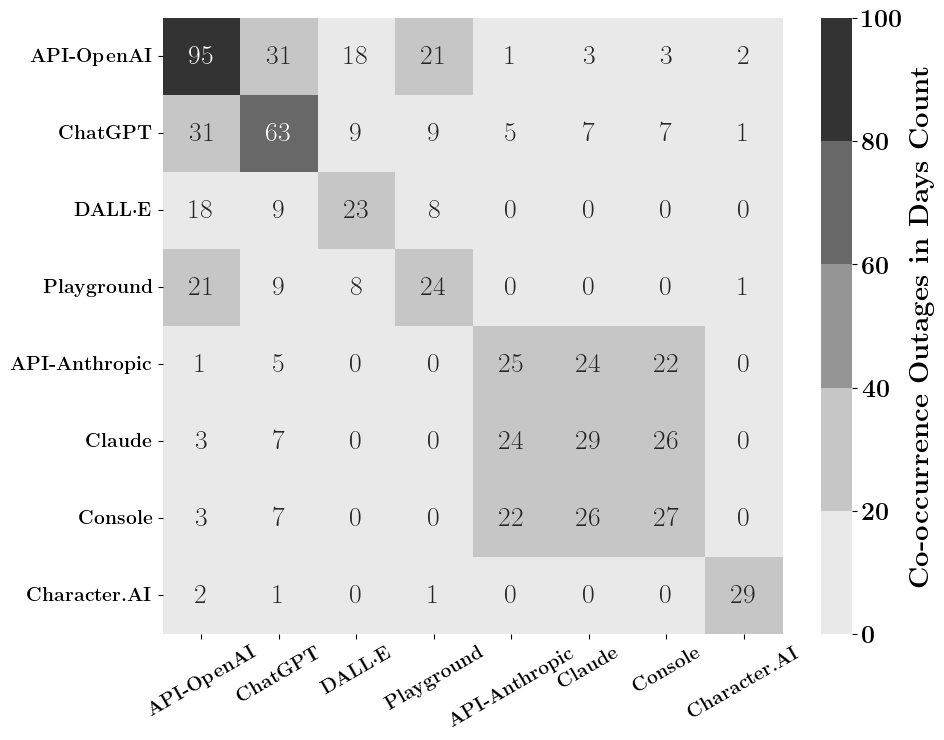

In [ ]:
# fig. outage count co-occurrence
set_one_column_figure_font(height_multiplier=1.0)

# Create the heatmap
plt.figure(figsize=(10, 8))
# give 5 grey colors
custom_colors = sns.color_palette('Greys', 5)
cmap = ListedColormap(custom_colors)
custom_bins = [0, 20, 40, 60, 80, 100]
norm = BoundaryNorm(custom_bins, cmap.N)
# mask = np.triu(np.ones_like(df_outage_count, dtype=bool), k=1)


sns.heatmap(df_outage_count, cmap=cmap, norm=norm, annot=True, cbar_kws={'label': r'\textbf{Co-occurrence Outages in Days Count}'}, annot_kws={'fontsize': 20})

# rotate the x-axis labels
plt.xticks(rotation=30)
tick_labels = [r'\textbf{API-OpenAI}', r'\textbf{ChatGPT}', r'\textbf{DALL·E}', r'\textbf{Playground}', r'\textbf{API-Anthropic}', r'\textbf{Claude}', r'\textbf{Console}', r'\textbf{Character.AI}']
plt.gca().set_xticklabels(tick_labels, fontsize=14)
plt.gca().set_yticklabels(tick_labels, fontsize=14)
# remove y-axis label
plt.ylabel('')

plt.savefig('plot/sec6-co_occurrence_failures/fig-outage_co-ocurrence_count.pdf', bbox_inches='tight')
plt.savefig('plot/sec6-co_occurrence_failures/fig-outage_co-ocurrence_count.png', bbox_inches='tight')
plt.show()

In [ ]:
18/95

0.18947368421052632

### fig. outage probability

In [ ]:
# Define the list of services
services = ['API-OpenAI', 'ChatGPT', 'DALL·E', 'Playground', 'API-Anthropic', 'Claude', 'Console', 'Character.AI']

outage_probability = {}
for service_ref in services:
    proportions = []
    for service_cmp in services:
        p = df_outage_flag[(df_outage_flag[service_cmp] > 0) & (df_outage_flag[service_ref] > 0)].shape[0] / df_outage_flag[df_outage_flag[service_cmp] > 0].shape[0]
        proportions.append(round(p * 100, 2))
    outage_probability[service_ref] = proportions

df_outage_probability = pd.DataFrame(outage_probability, index=services)
df_outage_probability = df_outage_probability.T
# df_outage_probability = df_outage_probability.astype(str) + '\%'

print(df_outage_probability)



               API-OpenAI  ChatGPT  DALL·E  Playground  API-Anthropic  Claude  \
API-OpenAI         100.00    49.21   78.26       87.50            4.0   10.34   
ChatGPT             32.63   100.00   39.13       37.50           20.0   24.14   
DALL·E              18.95    14.29  100.00       33.33            0.0    0.00   
Playground          22.11    14.29   34.78      100.00            0.0    0.00   
API-Anthropic        1.05     7.94    0.00        0.00          100.0   82.76   
Claude               3.16    11.11    0.00        0.00           96.0  100.00   
Console              3.16    11.11    0.00        0.00           88.0   89.66   
Character.AI         2.11     1.59    0.00        4.17            0.0    0.00   

               Console  Character.AI  
API-OpenAI       11.11          6.90  
ChatGPT          25.93          3.45  
DALL·E            0.00          0.00  
Playground        0.00          3.45  
API-Anthropic    81.48          0.00  
Claude           96.30          0.00

In [ ]:
# save the table
df_outage_probability.to_csv('plot/backup_table_csv/table-outage_probability.csv', index=False)
# to latex
print(df_outage_probability.to_latex(index=True))

\begin{tabular}{lllllllll}
\toprule
 & API-OpenAI & ChatGPT & DALL·E & Playground & API-Anthropic & Claude & Console & Character.AI \\
\midrule
API-OpenAI & 100.0\% & 49.21\% & 78.26\% & 87.5\% & 4.0\% & 10.34\% & 11.11\% & 6.9\% \\
ChatGPT & 32.63\% & 100.0\% & 39.13\% & 37.5\% & 20.0\% & 24.14\% & 25.93\% & 3.45\% \\
DALL·E & 18.95\% & 14.29\% & 100.0\% & 33.33\% & 0.0\% & 0.0\% & 0.0\% & 0.0\% \\
Playground & 22.11\% & 14.29\% & 34.78\% & 100.0\% & 0.0\% & 0.0\% & 0.0\% & 3.45\% \\
API-Anthropic & 1.05\% & 7.94\% & 0.0\% & 0.0\% & 100.0\% & 82.76\% & 81.48\% & 0.0\% \\
Claude & 3.16\% & 11.11\% & 0.0\% & 0.0\% & 96.0\% & 100.0\% & 96.3\% & 0.0\% \\
Console & 3.16\% & 11.11\% & 0.0\% & 0.0\% & 88.0\% & 89.66\% & 100.0\% & 0.0\% \\
Character.AI & 2.11\% & 1.59\% & 0.0\% & 4.17\% & 0.0\% & 0.0\% & 0.0\% & 100.0\% \\
\bottomrule
\end{tabular}



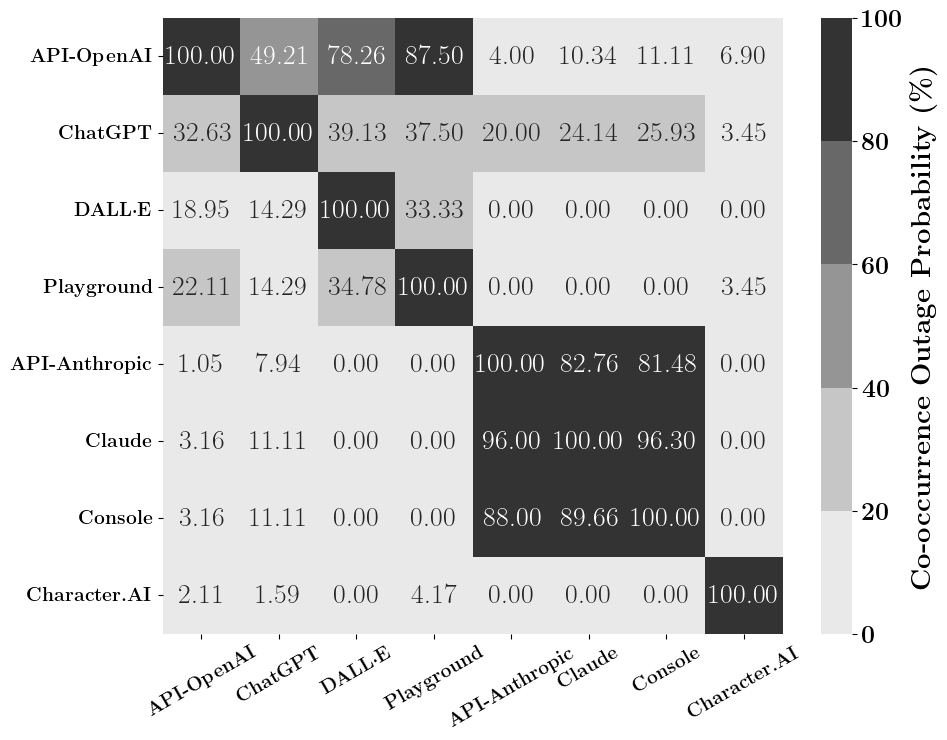

In [ ]:
# fig. outage probability
set_one_column_figure_font(height_multiplier=1.0)

# Create the heatmap
plt.figure(figsize=(10, 8))
# give 5 grey colors
custom_colors = sns.color_palette('Greys', 5)
cmap = ListedColormap(custom_colors)
custom_bins = [0, 20, 40, 60, 80, 100]
norm = BoundaryNorm(custom_bins, cmap.N)

sns.heatmap(df_outage_probability, cmap=cmap, norm=norm, annot=True, fmt=".2f", cbar_kws={'label': r'\textbf{Co-occurrence Outage Probability (\%)}'})

# rotate the x-axis labels
plt.xticks(rotation=30)
tick_labels = [r'\textbf{API-OpenAI}', r'\textbf{ChatGPT}', r'\textbf{DALL·E}', r'\textbf{Playground}', r'\textbf{API-Anthropic}', r'\textbf{Claude}', r'\textbf{Console}', r'\textbf{Character.AI}']
plt.gca().set_xticklabels(tick_labels, fontsize=14)
plt.gca().set_yticklabels(tick_labels, fontsize=14)

plt.savefig('plot/sec6-co_occurrence_failures/fig-outage_probability.pdf', bbox_inches='tight')
plt.savefig('plot/sec6-co_occurrence_failures/fig-outage_probability.png', bbox_inches='tight')
plt.show()


### (for observation) table. percent of outage days

In [ ]:
# calcute the number of days with outage
# select only the rows with outage_flag > 0
outage_days_percentage = []
for service in service_lst:
    df = dfs[service]
    p_service = df[df['outage_flag'] > 0].shape[0] / df.dropna().shape[0] * 100
    p_service = round(p_service, 2)
    outage_days_percentage.append(str(p_service)+'\%')

data = {
    'Service': service_lst,
    'Outage Days (%)': outage_days_percentage
}

df_outage_days_percent = pd.DataFrame(data).T
df_outage_days_percent.columns = df_outage_days_percent.iloc[0]
df_outage_days_percent = df_outage_days_percent[1:]
df_outage_days_percent


<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
/var/folders/y1/bc3yybl90rxfhtj2gdqnbwg80000gn/T/ipykernel_84014/3856341291.py:8: SyntaxWarning: invalid escape sequence '\%'
  outage_days_percentage.append(str(p_service)+'\%')


Service,API-OpenAI,ChatGPT,DALL·E,Playground,API-Anthropic,Claude,Console,Character.AI
Outage Days (%),7.32\%,11.15\%,4.12\%,1.92\%,5.98\%,6.94\%,6.46\%,9.12\%


In [ ]:
# save the table
df_outage_days_percent.to_csv('plot/backup_table_csv/table-outage_days_percent.csv', index=False)
# to latex
print(df_outage_days_percent.to_latex(index=False))

\begin{tabular}{llllllll}
\toprule
API-OpenAI & ChatGPT & DALL·E & Playground & API-Anthropic & Claude & Console & Character.AI \\
\midrule
7.32\% & 11.15\% & 4.12\% & 1.92\% & 5.98\% & 6.94\% & 6.46\% & 9.12\% \\
\bottomrule
\end{tabular}



## Impact Range of Incidents

In [ ]:
# load incident data
path = f'data/clean/incident/2024-08-31/incident_stages.csv'
df = pd.read_csv(path)

status_lst = ['investigating', 'identified', 'monitoring', 'resolved', 'postmortem', 'start']
for status in status_lst:
    df[f'{status}_timestamp'] = pd.to_datetime(df[f'{status}_timestamp'])

# rename columns
df.rename(columns={'API':'API-OpenAI', 'ChatGPT':'ChatGPT', 'Labs':'DALL·E', 'Playground':'Playground', 'api.anthropic.com':'API-Anthropic', 'claude.ai':'Claude', 'console.anthropic.com':'Console', 'Character.AI':'Character.AI'}, inplace=True)

service_lst = ['API-OpenAI', 'ChatGPT', 'DALL·E', 'Playground', 'API-Anthropic', 'Claude', 'Console', 'Character.AI']
dfs = {}
for service in service_lst:
    dfs[service] = df[df[service] == 1]
    dfs[service].reset_index(drop=True, inplace=True)

provider_lst = ['openai', 'anthropic', 'character']
dfs_provider = {}
for provider in provider_lst:
    for service in service_lst:
        if provider in dfs[service]['provider'].unique():
            dfs_provider[provider] = dfs_provider.get(provider, pd.DataFrame())
            dfs_provider[provider] = pd.concat([dfs_provider[provider], dfs[service][dfs[service]['provider'] == provider]], axis=0)

# display(dfs['API-OpenAI'])
display(dfs_provider['openai'].head())

,incident_id,Incident_Title,incident_impact_level,Incident_color,provider,Playground,API-OpenAI,DALL·E,ChatGPT,API-Anthropic,Claude,Console,Character.AI,investigating_flag,investigating_timestamp,investigating_description,identified_flag,identified_timestamp,identified_description,monitoring_flag,monitoring_timestamp,monitoring_description,resolved_flag,resolved_timestamp,resolved_description,postmortem_flag,postmortem_timestamp,postmortem_description,start_timestamp,close_timestamp,time_span,over_one_day
0,zm9ssldbs7ds,Increased queue wait times for GPT-3.5-Turbo f...,1,#f4ac36,openai,0,1,0,0,0,0,0,0,0,NaT,NaN,1,2024-02-29 20:41:00+00:00,We are seeing a spike in demand for 3.5 turbo ...,1,2024-03-01 02:16:00+00:00,The queue length is settling and wait times fo...,1,2024-03-01 04:13:00+00:00,This incident has been resolved.,0,NaT,NaN,2024-02-29 20:41:00+00:00,2024-03-01 04:13:00+00:00,0 days 07:32:00,False
1,62wkltqhbrmk,Elevated error rate impacting API services (in...,2,#e86c09,openai,0,1,0,0,0,0,0,0,1,2024-02-14 15:06:00+00:00,We are currently investigating this issue.,0,NaT,NaN,1,2024-02-14 18:38:00+00:00,A fix has been implemented and we are monitori...,1,2024-02-14 20:40:00+00:00,This incident has been resolved.,0,NaT,NaN,2024-02-14 15:06:00+00:00,2024-02-14 20:40:00+00:00,0 days 05:34:00,False
2,70p519qgngrw,Elevated errors on GPT-4V for ChatGPT and API,2,#e86c09,openai,0,1,0,1,0,0,0,0,1,2024-02-13 15:03:00+00:00,We are currently investigating this issue.,1,2024-02-13 15:36:00+00:00,The issue has been identified and a fix is bei...,1,2024-02-14 18:39:00+00:00,A fix has been implemented and we are monitori...,1,2024-02-14 20:40:00+00:00,This incident has been resolved.,0,NaT,NaN,2024-02-13 15:03:00+00:00,2024-02-14 20:40:00+00:00,1 days 05:37:00,True
3,mswp9vt22gm2,Elevated errors across multiple API endpoints ...,2,#e86c09,openai,0,1,0,1,0,0,0,0,1,2024-02-13 20:11:00+00:00,We are currently investigating this issue.,1,2024-02-13 20:38:00+00:00,We have identified this issue and a fix is bei...,1,2024-02-13 21:46:00+00:00,"A fix has been implemented, and we are monitor...",1,2024-02-13 23:38:00+00:00,This incident has been resolved.,0,NaT,NaN,2024-02-13 20:11:00+00:00,2024-02-13 23:38:00+00:00,0 days 03:27:00,False
4,shqybftjc7mc,Elevated errors on GPT-4V for ChatGPT and API,1,#f4ac36,openai,0,1,0,1,0,0,0,0,0,NaT,NaN,1,2024-02-12 17:19:00+00:00,We are currently investigating this issue.,1,2024-02-12 18:19:00+00:00,A fix has been implemented and we are monitori...,1,2024-02-12 18:39:00+00:00,This incident has been resolved.,0,NaT,NaN,2024-02-12 17:19:00+00:00,2024-02-12 18:39:00+00:00,0 days 01:20:00,False


In [ ]:
service_lst = ['API-OpenAI', 'ChatGPT', 'DALL·E', 'Playground', 'API-Anthropic', 'Claude', 'Console', 'Character.AI']
service_df = df[service_lst]

display(service_df)

In [4]:
service_df

,API-OpenAI,ChatGPT,DALL·E,Playground,API-Anthropic,Claude,Console,Character.AI
0,0,0,0,0,1,1,1,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,1,1,1,0
3,0,0,0,0,1,1,1,0
4,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...
537,1,0,0,0,0,0,0,0
538,1,0,0,0,0,0,0,0
539,0,0,0,1,0,0,0,0
540,1,0,0,1,0,0,0,0


In [103]:
openai_lst = ['API-OpenAI', 'ChatGPT', 'DALL·E', 'Playground']
anthropic_lst = ['API-Anthropic', 'Claude', 'Console']

openai_df = dfs_provider['openai'][openai_lst]
anthropic_df = dfs_provider['anthropic'][anthropic_lst]

openai_df['impact_range'] = openai_df.sum(axis=1)
openai_impact_counts = openai_df['impact_range'].value_counts().sort_index()
display(openai_impact_counts)
openai_df['impacted_services'] = openai_df.apply(lambda row: [service for service in openai_df.columns[:-1] if row[service] == 1], axis=1)
display(openai_df)

anthropic_df['impact_range'] = anthropic_df.sum(axis=1)
anthropic_impact_counts = anthropic_df['impact_range'].value_counts().sort_index()
display(anthropic_impact_counts)
anthropic_df['impacted_services'] = anthropic_df.apply(lambda row: [service for service in anthropic_df.columns[:-1] if row[service] == 1], axis=1)
display(anthropic_df)


impact_range
1    253
2    138
3     12
4     36
Name: count, dtype: int64

,API-OpenAI,ChatGPT,DALL·E,Playground,impact_range,impacted_services
0,1,0,0,0,1,[API-OpenAI]
1,1,0,0,0,1,[API-OpenAI]
2,1,1,0,0,2,"[API-OpenAI, ChatGPT]"
3,1,1,0,0,2,"[API-OpenAI, ChatGPT]"
4,1,1,0,0,2,"[API-OpenAI, ChatGPT]"
...,...,...,...,...,...,...
28,1,0,0,1,2,"[API-OpenAI, Playground]"
29,1,0,0,1,2,"[API-OpenAI, Playground]"
30,0,0,0,1,1,[Playground]
31,1,0,0,1,2,"[API-OpenAI, Playground]"


impact_range
1     30
2     36
3    168
Name: count, dtype: int64

,API-Anthropic,Claude,Console,impact_range,impacted_services
0,1,1,1,3,"[API-Anthropic, Claude, Console]"
1,1,1,1,3,"[API-Anthropic, Claude, Console]"
2,1,1,1,3,"[API-Anthropic, Claude, Console]"
3,1,1,1,3,"[API-Anthropic, Claude, Console]"
4,1,1,1,3,"[API-Anthropic, Claude, Console]"
...,...,...,...,...,...
67,1,1,1,3,"[API-Anthropic, Claude, Console]"
68,1,1,1,3,"[API-Anthropic, Claude, Console]"
69,0,1,1,2,"[Claude, Console]"
70,1,1,1,3,"[API-Anthropic, Claude, Console]"


In [118]:
# create a impact range dataframe
impact_range_df = pd.DataFrame()
impact_range_df['OpenAI'] = openai_impact_counts
impact_range_df['Anthropic'] = anthropic_impact_counts
impact_range_df.T

# transform to percentage
impact_range_percent = impact_range_df.T.div(impact_range_df.T.sum(axis=1), axis=0) * 100
impact_range_percent = impact_range_percent.round(2)
display(impact_range_percent)

# print to latex
print(impact_range_percent.to_latex())

impact_range,1,2,3,4
OpenAI,57.63,31.44,2.73,8.2
Anthropic,12.82,15.38,71.79,NaN


\begin{tabular}{lrrrr}
\toprule
impact_range & 1 & 2 & 3 & 4 \\
\midrule
OpenAI & 57.630000 & 31.440000 & 2.730000 & 8.200000 \\
Anthropic & 12.820000 & 15.380000 & 71.790000 & NaN \\
\bottomrule
\end{tabular}



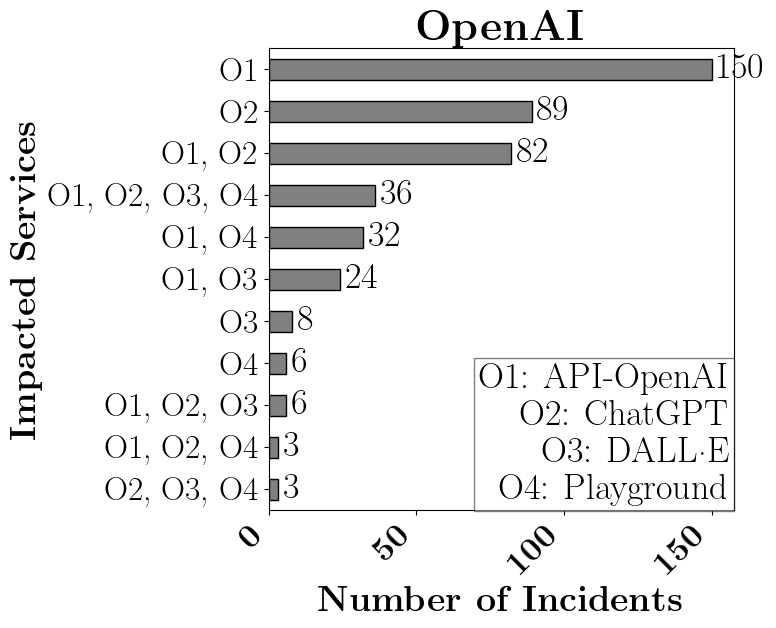

In [106]:
# Plot bar chart of impacted service combinations, OpenAI

openai_df['impacted_services_str'] =openai_df['impacted_services'].apply(lambda x: ', '.join(x))
impacted_combinations_counts = openai_df['impacted_services_str'].value_counts()

service_labels = {
    'API-OpenAI': 'O1',
    'ChatGPT': 'O2',
    'DALL·E': 'O3',
    'Playground': 'O4'
}

# Apply mapping to the impacted services column
openai_df['impacted_services_short'] = openai_df['impacted_services'].apply(lambda services: [service_labels[service] for service in services])
openai_df['impacted_services_short_str'] = openai_df['impacted_services_short'].apply(lambda x: ', '.join(x))
impacted_combinations_counts_short = openai_df['impacted_services_short_str'].value_counts()
# rename the NaN to None
impacted_combinations_counts_short = impacted_combinations_counts_short.rename(index={'': 'Not Given'})

# Plot bar chart of impacted service combinations
set_half_column_figure_font(height_multiplier=1.0)
plt.figure(figsize=(6, 6))
impacted_combinations_counts_short[::-1].plot(kind='barh', color='grey', edgecolor='black')
# add the count labels to each bar
for i, count in enumerate(impacted_combinations_counts_short[::-1]):
    plt.text(count+2, i, str(count), ha='left', va='center', fontsize=25.9, color='black')
plt.title(r"\textbf{OpenAI}")
plt.ylabel(r"\textbf{Impacted Services}")
plt.xlabel(r"\textbf{Number of Incidents}")
plt.xticks(rotation=45, ha="right")

# Add a text box to show the O1, O2, O3, O4 mapping at the top right corner
plt.text(0.99, 0.01, "O1: API-OpenAI\nO2: ChatGPT\nO3: DALL·E\nO4: Playground", ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=25.9, bbox=dict(facecolor='white', alpha=0.5))
# save
plt.savefig('plot/sec6-co_occurrence_failures/fig-incident_impacted_service_combinations_openai.pdf', bbox_inches='tight')
plt.savefig('plot/sec6-co_occurrence_failures/fig-incident_impacted_service_combinations_openai.png', bbox_inches='tight')
plt.show()

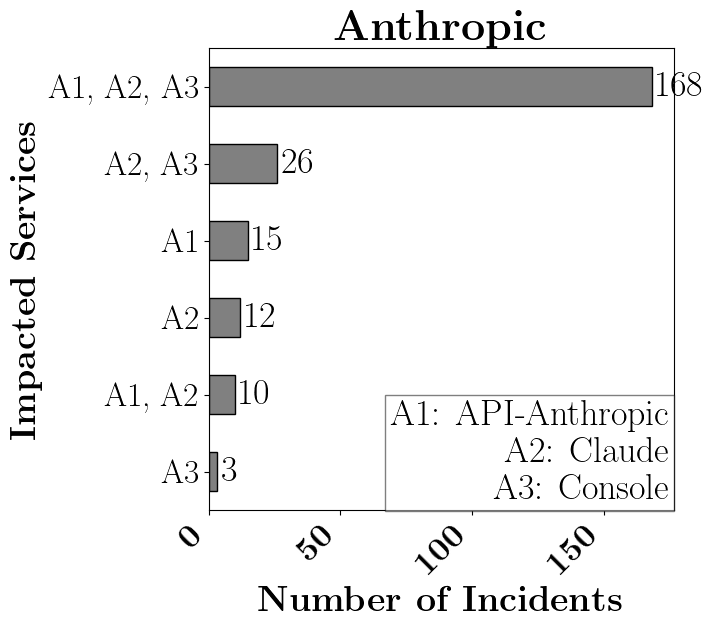

In [107]:
# Plot bar chart of impacted service combinations, Anthropic

anthropic_df['impacted_services'].value_counts()
anthropic_df['impacted_services_str'] =anthropic_df['impacted_services'].apply(lambda x: ', '.join(x))
impacted_combinations_counts = anthropic_df['impacted_services_str'].value_counts()

service_labels = {
    'API-Anthropic': 'A1',
    'Claude': 'A2',
    'Console': 'A3'
}

# Apply mapping to the impacted services column
anthropic_df['impacted_services_short'] = anthropic_df['impacted_services'].apply(lambda services: [service_labels[service] for service in services])
anthropic_df['impacted_services_short_str'] = anthropic_df['impacted_services_short'].apply(lambda x: ', '.join(x))
impacted_combinations_counts_short = anthropic_df['impacted_services_short_str'].value_counts()
# rename the NaN to None
impacted_combinations_counts_short = impacted_combinations_counts_short.rename(index={'': 'Not Given'})

# Plot bar chart of impacted service combinations
set_half_column_figure_font(height_multiplier=1.0)
plt.figure(figsize=(6, 6))
impacted_combinations_counts_short[::-1].plot(kind='barh', color='grey', edgecolor='black')
# add the count labels to each bar
for i, count in enumerate(impacted_combinations_counts_short[::-1]):
    plt.text(count+2, i, str(count), ha='left', va='center', fontsize=25.9, color="black")
plt.title(r"\textbf{Anthropic}")
plt.ylabel(r"\textbf{Impacted Services}")
plt.xlabel(r"\textbf{Number of Incidents}")
plt.xticks(rotation=45, ha="right")

# Add a text box to show the O1, O2, O3, O4 mapping at the top right corner
plt.text(0.99, 0.01, "A1: API-Anthropic\nA2: Claude\nA3: Console", ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=25.9, bbox=dict(facecolor='white', alpha=0.5))
# save 
plt.savefig('plot/sec6-co_occurrence_failures/fig-incident_impacted_service_combinations_anthropic.pdf', bbox_inches='tight')
plt.savefig('plot/sec6-co_occurrence_failures/fig-incident_impacted_service_combinations_anthropic.png', bbox_inches='tight')
plt.show()
